# 第8章: ニューラルネット
第6章で取り組んだニュース記事のカテゴリ分類を題材として，ニューラルネットワークでカテゴリ分類モデルを実装する．なお，この章ではPyTorch, TensorFlow, Chainerなどの機械学習プラットフォームを活用せよ．

## 70. 単語ベクトルの和による特徴量
問題50で構築した学習データ，検証データ，評価データを行列・ベクトルに変換したい．例えば，学習データについて，すべての事例の特徴ベクトルを並べた行列Xと正解ラベルを並べた行列（ベクトル）Yを作成したい．
$$
    X = \left(
    \begin{array}{c}
      x_1 \\
      x_2 \\
      \vdots \\
      x_n
    \end{array}
  \right) \in \mathbb{R}^{n\times d},
    Y = \left(
    \begin{array}{c}
      y_1 \\
      y_2 \\
      \vdots \\
      y_n
    \end{array}
  \right) \in \mathbb{N}^{n}
$$
ここで，nは学習データの事例数であり，$x_i\in\mathbb{R^d}$と$y_i\in\mathbb{N}$はそれぞれ，$i\in\{1,…,n\}$番目の事例の特徴量ベクトルと正解ラベルを表す． なお，今回は「ビジネス」「科学技術」「エンターテイメント」「健康」の4カテゴリ分類である．$\mathbb{N_4}$で4未満の自然数（0を含む）を表すことにすれば，任意の事例の正解ラベル$y_i$は$y_i\in\mathbb{N_4}$で表現できる． 以降では，ラベルの種類数をLで表す（今回の分類タスクではL=4である）．
$i$番目の事例の特徴ベクトル$x_i$は，次式で求める．
$$ x_i=\frac{1}{T_i}\sum_{t=1}^{T_i}emb(w_{i,t})$$
ここで，i番目の事例はTi個の（記事見出しの）単語列$(w_{i,1},w_{i,2},…,w_{i,T_i})$から構成され，$emb(w)\in \mathbb{R}^d$は単語wに対応する単語ベクトル（次元数はd）である．すなわち，i番目の事例の記事見出しを，その見出しに含まれる単語のベクトルの平均で表現したものが$x_i$である．今回は単語ベクトルとして，問題60でダウンロードしたものを用いればよい．300次元の単語ベクトルを用いたので，d=300である．
i番目の事例のラベル$y_i$は，次のように定義する．

\begin{eqnarray}
    y_i=\left\{ \begin{array}{ll}
    0 & (記事x_iが「ビジネス」カテゴリの場合) \\
    1 & (記事x_iが「科学技術」カテゴリの場合) \\
    2 & (記事x_iが「エンターテインメント」カテゴリの場合) \\
    3 & (記事x_iが「健康」カテゴリの場合) \\
    \end{array} \right.
\end{eqnarray}

なお，カテゴリ名とラベルの番号が一対一で対応付いていれば，上式の通りの対応付けでなくてもよい．

以上の仕様に基づき，以下の行列・ベクトルを作成し，ファイルに保存せよ．

- 学習データの特徴量行列: $X_{train}\in \mathbb{R}^{N_t\times d}$
- 学習データのラベルベクトル: $Y_{train}\in \mathbb{N}^{N_t}$
- 検証データの特徴量行列: $X_{valid}\in \mathbb{R}^{N_v\times{d}}$
- 検証データのラベルベクトル: $Y_{valid}\in \mathbb{N}^{N_v}$
- 評価データの特徴量行列: $X_{test}\in \mathbb{R}^{N_e \times{d}}$
- 評価データのラベルベクトル: $Y_{test}\in \mathbb{N}^{N_e}$

なお，$N_t$,$N_v$,$N_e$はそれぞれ，学習データの事例数，検証データの事例数，評価データの事例数である．

In [1]:
from gensim.models import KeyedVectors
w2v = KeyedVectors.load_word2vec_format('../Chapter07/GoogleNews-vectors-negative300.bin', binary=True)

unable to import 'smart_open.gcs', disabling that module


In [2]:
import pandas as pd
news = pd.read_csv('../Chapter06/newsCorpora.csv', sep="\t", header=None, names=["ID","TITLE","URL","PUBLISHER","CATEGORY","STORY","HOSTNAME","TIMESTAMP"],index_col="ID")
news = news.query('PUBLISHER in ["Reuters","Huffington Post","Businessweek", "Contactmusic.com", "Daily Mail"]')
news = news.sample(frac=1,random_state=0)
news = news[["TITLE","CATEGORY"]]

In [3]:
import spacy
nlp = spacy.load('en_core_web_sm')
def genword(title):
    for word in nlp(title): yield word.lemma_

from stemming.porter2 import stem
def word2vec(word):
    if word in w2v: return w2v[word]
    if stem(word) in w2v: return w2v[stem(word)]
    return None

import numpy as np
def summation(li):
    return np.average([vec for vec in li if vec is not None],axis=0)

(b = business, t = science and technology, e = entertainment, m = health)

In [4]:
news['TITLE'] = news['TITLE'].apply(lambda title:summation([word2vec(word) for word in genword(title)]))
news['CATEGORY'] = news['CATEGORY'].apply(lambda cate:'btem'.find(cate))

In [5]:
convert = lambda values,dtype:np.array([elm.astype(np.float) for elm in values],dtype=dtype)

In [6]:
news_X = convert(news['TITLE'].values,dtype=float)
news_Y = convert(news['CATEGORY'].values,dtype=int)

In [7]:
from sklearn.model_selection import train_test_split
test_valid_X, train_X, test_valid_Y, train_Y = train_test_split(news_X, news_Y, test_size=0.8, random_state=0)
test_X, valid_X, test_Y, valid_Y = train_test_split(test_valid_X, test_valid_Y, test_size=0.5, random_state=0)

In [8]:
import pickle
for mode in ["train","test","valid"]:
    with open(f"{mode}_X.pickle", 'wb') as f: pickle.dump(eval(f"{mode}_X"), f)
    with open(f"{mode}_Y.pickle", 'wb') as f: pickle.dump(eval(f"{mode}_Y"), f)

## 71. 単層ニューラルネットワークによる予測
問題70で保存した行列を読み込み，学習データについて以下の計算を実行せよ．
$$
    \hat{y}_1 = softmax(x_i W), \\
    \hat{Y} = softmax(X_{[1:4]}W)
$$
ただし，softmaxはソフトマックス関数，$X_{[1:4]}\in\mathbb{R}^{4\times d}$は特徴ベクトル$x_1,x_2,x_3,x_4$を縦に並べた行列である．

$$
X_{[1:4]}= \left(
    \begin{array}{c}
      x_1 \\
      x_2 \\
      x_3 \\
      x_4
    \end{array}
  \right)
$$

行列$W\in R^{d\times L}$は単層ニューラルネットワークの重み行列で，ここではランダムな値で初期化すればよい（問題73以降で学習して求める）．なお，$\hat{y}_1\in\mathbb{N}^L$は未学習の行列Wで事例$x_1$を分類したときに，各カテゴリに属する確率を表すベクトルである． 同様に，$\hat{Y}\in\mathbb{N}^{n\times L}$は，学習データの事例$x_1,x_2,x_3,x_4$について，各カテゴリに属する確率を行列として表現している．

In [9]:
for mode in ["train","test","valid"]:
    with open(f"{mode}_X.pickle", 'rb') as f: exec(f"{mode}_X = pickle.load(f); print('{mode}_X was filled')")
    with open(f"{mode}_Y.pickle", 'rb') as f: exec(f"{mode}_Y = pickle.load(f); print('{mode}_Y was filled')")

train_X was filled
train_Y was filled
test_X was filled
test_Y was filled
valid_X was filled
valid_Y was filled


In [10]:
d = 300; l = 4
W = np.random.randn(d,l)

In [11]:
def softmax(x):
    if x.ndim == 1: x = x[None,:]
    e_x = np.exp(x.T - np.max(x,axis=1).T).T
    return (e_x.T / e_x.sum(axis=1).T).T

In [12]:
softmax(np.dot(train_X[0],W))

array([[0.11211628, 0.32845638, 0.52268685, 0.03674049]])

In [13]:
softmax(np.dot(train_X[:4],W))

array([[0.11211628, 0.32845638, 0.52268685, 0.03674049],
       [0.45342302, 0.09824919, 0.42111959, 0.02720821],
       [0.39886844, 0.18633846, 0.12494852, 0.28984458],
       [0.5770489 , 0.04235514, 0.36679768, 0.01379828]])

## 72. 損失と勾配の計算
学習データの事例x1と事例集合x1,x2,x3,x4に対して，クロスエントロピー損失と，行列Wに対する勾配を計算せよ．なお，ある事例xiに対して損失は次式で計算される．

$l_i=−\log p(y_i|x_i)$, $j:=y_i$, $a:=xW$, $o_j=p(y_i)=softmax((xW)_{y_i})=softmax(a_j)$, 

ただし，事例集合に対するクロスエントロピー損失は，その集合に含まれる各事例の損失の平均とする．

In [14]:
class Linear:
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.W = np.random.randn(input_size, output_size)
        self.dW = np.zeros((input_size, output_size),dtype=float)
        self.x = None
        
    def forward(self, x):
        self.x = x
        out = np.dot(self.x, self.W)
        if np.isnan(out).any() or np.isinf(out).any(): raise Exception(out, self.x, self.W)
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        dW = np.outer(self.x.T, dout)
        self.dW = dW
        return np.resize(dx,self.input_size)
    
    def update(self, lr):
        self.W -= lr * self.dW

In [15]:
class Loss:
    def __init__(self, y_size):
        self.y_size = y_size
    def forward(self, pred_y, y):
        self.y = y
        self.out = pred_y[0][y]
        out = -np.log(np.max([self.out,1e-6]))
        if np.isnan(out).any() or np.isinf(out).any(): raise Exception(out, self.out)
        return out
    def backward(self):
        ret = np.zeros(self.y_size)
        ret[y] = -1/np.max([self.out,1e-6])
        return ret

+ grad softmax

$\displaystyle o_i=softmax(a_i)=\frac{\exp(a_i)}{\sum_k{\exp(a_k)}}$

$\displaystyle \frac{\partial{o_i}}{\partial a_i}=\frac{\exp(a_i)\sum_k(\exp(a_k))-\exp(a_i)\exp(a_i)}{(\sum_k{\exp(a_k)})^2}=o_i-o_io_i=o_i(1-o_i)$

$\displaystyle \frac{\partial{o_i}}{\partial a_{j(\neq i)}}=\frac{-\exp(a_i)\exp(a_j)}{(\sum_k{\exp(a_k)})^2}=-o_io_j$

$\therefore \displaystyle \frac{\partial{o_i}}{\partial a_j}=\frac{\partial}{\partial a_j}softmax(a_i)=o_i(\delta_{ij}-o_j)$

In [16]:
class Softmax: # backwardは完全にこの問題に合わせたもの
    def forward(self, x):
        if x.ndim == 1: x = x[None,:]
        e_x = np.exp(x.T - np.max(x,axis=1).T).T
        self.out = (e_x.T / e_x.sum(axis=1).T).T
        if np.isnan(self.out).any() or np.isinf(self.out).any(): raise Exception(self.out)
        return self.out
    
    def backward(self, dout):
        y = np.where(dout != 0)[0]
        p = np.empty_like(dout)
        p[y] = 1
        return dout[y] * (p - self.out)
    def update(self, lr):
        pass

+ まとめて

$\displaystyle \frac{\partial{l_i}}{\partial W_{kl}}=\frac{\partial(-\log o_j)}{\partial W_{kl}}=-\frac{1}{o_j}\frac{\partial}{\partial W_{kl}}softmax(a_j)$

$\displaystyle =-\frac{1}{o_j}\sum_n\frac{\partial}{\partial a_n}softmax(a_j)\frac{\partial a_n}{\partial W_{kl}}$

$\displaystyle =-\frac{1}{o_j}\sum_n{o_j(\delta_{jn}-o_n)}\frac{\partial a_n}{\partial W_{kl}} = -\sum_n{(\delta_{jn}-o_n)}\frac{\partial a_n}{\partial W_{kl}}$

$\displaystyle = -\sum_n{(\delta_{jn}-o_n)}\delta_{nl}x_k$

$\displaystyle = -(\delta_{jl}-o_l)x_k$

In [17]:
class MyModel:
    def __init__(self, dim=300, l=4):
        self.layers = [
            Linear(input_size=dim, output_size=l),
            Softmax()
        ]
        self.losslayer = Loss(y_size=l)
        
    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def forward(self, x, y):
        pred_y = self.predict(x)
        loss = self.losslayer.forward(pred_y, y)
        return loss
    
    def backward(self):
        dout = self.losslayer.backward()
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def update(self, lr):
        for layer in self.layers:
            layer.update(lr)

In [18]:
def grad(pred_y:np.ndarray, y:int, x:np.ndarray):
    grad_W = np.empty_like(W) # d*l
    for i in range(len(l)):
        grad_W[:,i] = ((int)(y==i)-pred_y[i])*x[:]
    return grad_W

In [19]:
model = MyModel(dim=300, l=4)

In [20]:
model.predict(train_X[:4])

array([[0.38021665, 0.11805815, 0.35667805, 0.14504714],
       [0.46557304, 0.1026168 , 0.32559059, 0.10621958],
       [0.52169199, 0.12184181, 0.26712265, 0.08934354],
       [0.77428984, 0.05464248, 0.12055478, 0.0505129 ]])

## 73. 確率的勾配降下法による学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列Wを学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）．

In [21]:
class SGD:
    def __init__(self, model, lr=0.01):
        self.model = model
        self.lr = lr
        
    def update(self):
        model.update(self.lr)

In [22]:
def accuracy(model,mode):
    pred_Y = model.predict(eval(f"{mode}_X"))
    y = eval(f"{mode}_Y")
    a = [(bool)(t==p) for t,p in zip(pred_Y.argmax(axis=1),y)]
    return sum(a)/len(a)

In [23]:
model = MyModel(dim=300, l=4)
optimizer = SGD(model)
for i in range(10):
    for j,(x,y) in enumerate(zip(train_X,train_Y)):
        loss = model.forward(x, y)
        model.backward()
        optimizer.update()
    print(f"accuracy: {accuracy(model,'valid')*100}%")

accuracy: 85.00749625187406%
accuracy: 84.40779610194903%
accuracy: 85.83208395802099%
accuracy: 85.83208395802099%
accuracy: 86.28185907046478%
accuracy: 85.83208395802099%
accuracy: 85.68215892053973%
accuracy: 85.75712143928035%
accuracy: 86.05697151424287%
accuracy: 86.05697151424287%


+ pytorchで書いてみる

In [24]:
import torch

In [25]:
for mode in ["train","test","valid"]:
    exec(f"{mode}_X = torch.tensor({mode}_X)")
    exec(f"{mode}_Y = torch.tensor({mode}_Y)")

In [26]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear = nn.Linear(300, 4, False).double()
        self.loss = nn.CrossEntropyLoss()
    
    def predict(self, x):
        return F.softmax(self.linear(x),dim=1)
        
    def forward(self, x, y):
        return self.loss(self.linear(x), y)

In [27]:
import copy
class DataLoader:
    def __init__(self, *, mode, shuffle=False, batch_size=1):
        if mode not in ["train","test","valid"]: raise Exception("invalid mode")
        self.X, self.Y = eval(f"{mode}_X"), eval(f"{mode}_Y")
        if shuffle: 
            index = np.random.shuffle(list(range(len(self.X))))
            self.X = self.X[index][0]
            self.Y = self.Y[index][0]
        self.batch_size = batch_size
        self.pointer = 0
        self.size = len(self.X)
    
    def reset(self):
        self.pointer = 0
        return self
    
    def generator(self):
        b = self.batch_size
        p = self.pointer
        if p >= self.size: return
        if p+b >= self.size: b = self.size - p
        self.pointer += b
        yield [self.X[p:p+b],self.Y[p:p+b]]
    
    def __call__(self):
        return self.generator()

In [28]:
import torch.optim as optim

model = Model()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
trainLoader = DataLoader(mode="train",shuffle=True, batch_size=50)
pre_acc = 0.
pre_model = None
for i in range(10000):
    trainLoader.reset()
    for x,y in trainLoader():
        loss = model(x, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    acc = accuracy(model,"valid")
    if acc > pre_acc:
        pre_model = copy.deepcopy(model)
        if i > 100: print(f">> {i} epoch, good accuracy: {acc*100}%")
        pre_acc = acc
    if i%1000 == 0: print(f"{i} epoch, accuracy: {acc*100}%")

0 epoch, accuracy: 26.686656671664167%
>> 333 epoch, good accuracy: 75.63718140929535%
>> 394 epoch, good accuracy: 75.71214392803599%
>> 427 epoch, good accuracy: 75.86206896551724%
>> 517 epoch, good accuracy: 75.93703148425787%
>> 678 epoch, good accuracy: 76.01199400299849%
>> 850 epoch, good accuracy: 76.08695652173914%
>> 994 epoch, good accuracy: 76.16191904047976%
1000 epoch, accuracy: 76.16191904047976%
>> 1177 epoch, good accuracy: 76.2368815592204%
>> 1259 epoch, good accuracy: 76.31184407796103%
>> 1695 epoch, good accuracy: 76.38680659670165%
>> 1765 epoch, good accuracy: 76.46176911544228%
2000 epoch, accuracy: 76.46176911544228%
>> 2178 epoch, good accuracy: 76.53673163418291%
>> 2660 epoch, good accuracy: 76.61169415292353%
>> 2730 epoch, good accuracy: 76.68665667166417%
>> 2762 epoch, good accuracy: 76.7616191904048%
3000 epoch, accuracy: 76.7616191904048%
>> 3073 epoch, good accuracy: 76.83658170914542%
>> 3474 epoch, good accuracy: 76.91154422788605%
4000 epoch, acc

In [29]:
accuracy(pre_model, "test")

0.7886056971514243

## 74. 正解率の計測
問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ．

上記

## 75. 損失と正解率のプロット
問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ．

In [30]:
import matplotlib.pyplot as plt
import japanize_matplotlib

def disp(epoch, loss,train_acc,valid_loss,valid_acc):
    for elm in ["epoch","loss","train_acc","valid_loss","valid_acc"]:
        record[elm].append(eval(elm))
    
    fig = plt.figure(figsize=(14,6))
    lossfig = fig.add_subplot(1,2,1)
    lossfig.set_title("loss")
    lossfig.plot(record["epoch"], record["loss"], label="train")
    lossfig.plot(record["epoch"], record["valid_loss"], label="valid")
    accfig = fig.add_subplot(1,2,2)
    accfig.set_title("accuracy")
    accfig.plot(record["epoch"], record["train_acc"], label="train")
    accfig.plot(record["epoch"], record["valid_acc"], label="valid")
    plt.legend()
    plt.show()

/home/maruyama.y/_/lib/python3.8/site-packages/japanize_matplotlib/japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


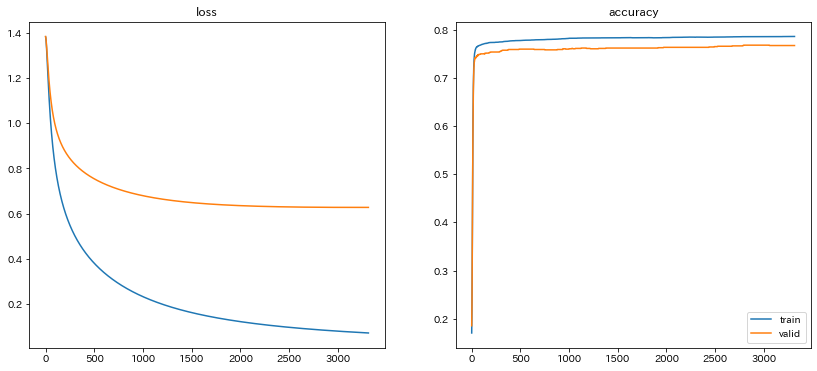

In [31]:
from IPython.display import clear_output
model = Model()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
trainLoader = DataLoader(mode="train",shuffle=True, batch_size=50)
validLoader = DataLoader(mode="valid",shuffle=True, batch_size=len(valid_X))
pre_loss = 1000000.
count = 0
pre_model = None
record = {"epoch":[],"loss":[], "train_acc":[], "valid_loss":[], "valid_acc":[]}
for i in range(10000):
    trainLoader.reset()
    for x,y in trainLoader():
        loss = model(x, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_acc = accuracy(model,"train")
    
    validLoader.reset()
    x,y = validLoader().__next__()
    valid_loss = model(x, y)
    valid_acc = accuracy(model,"valid")
    if valid_loss < pre_loss:
        pre_model = copy.deepcopy(model)
        pre_loss = valid_loss
    else: count += 1
    clear_output()
    disp(i, loss, train_acc, valid_loss, valid_acc)  
    if count > 100: break

## 76. チェックポイント
問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ．

In [32]:
import os
model = Model()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
trainLoader = DataLoader(mode="train",shuffle=True, batch_size=50)
validLoader = DataLoader(mode="valid",shuffle=True, batch_size=len(valid_X))
pre_loss = 100000.
count = 0
for i in range(10000):
    trainLoader.reset()
    for x,y in trainLoader():
        loss = model(x, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_acc = accuracy(model,"train")
    
    validLoader.reset()
    x,y = validLoader().__next__()
    valid_loss = model(x, y)
    valid_acc = accuracy(model,"valid")
    if i>200 and valid_loss < pre_loss:
        os.makedirs('models',exist_ok=True)
        with open(f"models/model_e{i}.pickle",'wb') as f: pickle.dump(model, f)
        with open(f"models/optimizer_e{i}.pickle",'wb') as f: pickle.dump(optimizer, f)
        pre_loss = valid_loss
    else: count += 1 
    if count > 100: break

## 77. ミニバッチ化
問題76のコードを改変し，B事例ごとに損失・勾配を計算し，行列Wの値を更新せよ（ミニバッチ化）．Bの値を1,2,4,8,…と変化させながら，1エポックの学習に要する時間を比較せよ．

In [33]:
import time
model = Model()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
validLoader = DataLoader(mode="valid",shuffle=True, batch_size=len(valid_X))
pre_loss = 100000.
count = 0
Bs = []
times = []
for b in range(14):
    B = 2**b
    start = time.time()
    for i in range(1000):
        trainLoader = DataLoader(mode="train",shuffle=True, batch_size=B).reset()
        for x,y in trainLoader():
            loss = model(x, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    end = time.time()
    Bs.append(B)
    times.append(end-start)

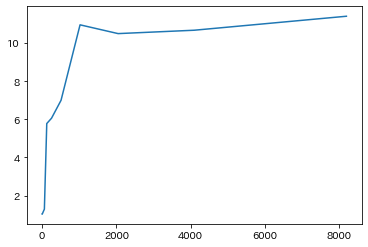

In [34]:
plt.plot(Bs,times)

## 78. GPU上での学習
問題77のコードを改変し，GPU上で学習を実行せよ．

In [35]:
model = Model().cuda()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
validLoader = DataLoader(mode="valid",shuffle=True, batch_size=len(valid_X))
pre_loss = 100000.
count = 0
Bs = []
times = []
for b in range(14):
    B = 2**b
    start = time.time()
    for i in range(1000):
        trainLoader = DataLoader(mode="train",shuffle=True, batch_size=B).reset()
        for x,y in trainLoader():
            x = x.cuda(); y = y.cuda()
            loss = model(x, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    end = time.time()
    Bs.append(B)
    times.append(end-start)

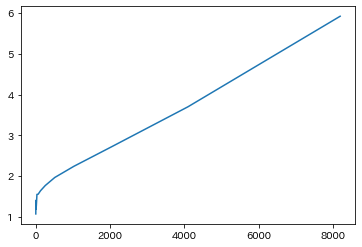

In [36]:
plt.plot(Bs,times)

## 79. 多層ニューラルネットワーク
問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ．

In [37]:
class MModel(nn.Module):
    def __init__(self):
        super(MModel, self).__init__()
        self.lin1 = nn.Linear(300,60).double()
        self.lin2 = nn.Linear(60,4).double()
        self.losslayer = nn.CrossEntropyLoss()
    
    def predict(self,x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        return x
    
    def forward(self,x,y):
        pred_y = self.predict(x)
        loss = self.losslayer(pred_y, y)
        return loss

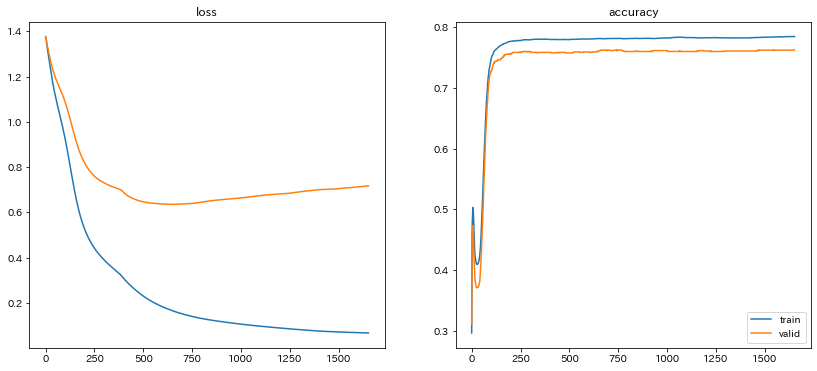

In [38]:
model = MModel()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
trainLoader = DataLoader(mode="train",shuffle=True, batch_size=50)
validLoader = DataLoader(mode="valid",shuffle=True, batch_size=len(valid_X))
pre_loss = 1000000.
count = 0
pre_model = None
record = {"epoch":[],"loss":[], "train_acc":[], "valid_loss":[], "valid_acc":[]}
for i in range(10000):
    trainLoader.reset()
    for x,y in trainLoader():
        loss = model(x, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_acc = accuracy(model,"train")
    
    validLoader.reset()
    x,y = validLoader().__next__()
    valid_loss = model(x, y)
    valid_acc = accuracy(model,"valid")
    if valid_loss < pre_loss:
        pre_model = copy.deepcopy(model)
        pre_loss = valid_loss
    else: count += 1
    clear_output()
    disp(i, loss, train_acc, valid_loss, valid_acc)  
    if count > 1000: break